In [23]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

# Parâmetros
img_size = (224, 224)
batch_size = 16

# Carregar o dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/meu_dataset",  # pasta com as subpastas de classes
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/meu_dataset", # Corrected path to use the same base directory
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Pré-processamento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Criar o modelo com transferência de aprendizado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Camadas extras
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names), activation='softmax', name='output')

# Montar o modelo
inputs = tf.keras.Input(shape=img_size + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = global_avg(x)
x = layers.Dense(128, activation='relu', name='feature_layer')(x)  # << camada intermediária
outputs = output_layer(x)

model = tf.keras.Model(inputs, outputs)

# Compilar
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Found 15 files belonging to 4 classes.
Using 12 files for training.
Found 15 files belonging to 4 classes.
Using 3 files for validation.
Classes: ['camisa_normal', 'camisa_time', 'chinelo', 'relogio_smartwatch']
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.1667 - loss: 2.0295 - val_accuracy: 0.0000e+00 - val_loss: 1.9168
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step - accuracy: 0.6667 - loss: 0.7898 - val_accuracy: 0.3333 - val_loss: 1.6743
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.3903 - val_accuracy: 0.6667 - val_loss: 1.0829
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1636 - val_accuracy: 0.6667 - val_loss: 0.6505
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0737 - val_accuracy: 0.6667 - val_loss: 0.3892


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Diretório do seu dataset
dataset_path = '/content/drive/MyDrive/meu_dataset'

# Criar gerador de imagens
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

img_size = (224, 224) # Changed from (100, 100) to (224, 224)
batch_size = 32

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Nomes das classes detectadas
print(train_generator.class_indices)

Found 15 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'camisa_normal': 0, 'camisa_time': 1, 'chinelo': 2, 'relogio_smartwatch': 3}


In [26]:
import tensorflow as tf

feature_model = tf.keras.Model(inputs=model.input,
                               outputs=model.get_layer('feature_layer').output)

In [27]:
feature_model = tf.keras.Model(inputs=model.input,
                               outputs=model.get_layer('feature_layer').output)


In [28]:
import numpy as np

features = []
labels = []

for i in range(len(train_generator)):
    x_batch, y_batch = train_generator[i]
    feature_batch = feature_model.predict(x_batch)
    features.append(feature_batch)
    labels.append(y_batch)
    if i >= train_generator.samples // batch_size:
        break

features = np.vstack(features)
labels = np.concatenate(labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [29]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def recomendar_similares(imagem, top_k=5):
    imagem = tf.image.resize(imagem, img_size)
    imagem = tf.expand_dims(imagem, axis=0)
    imagem = imagem / 255.0

    vetor = feature_model.predict(imagem)
    similaridades = cosine_similarity(vetor, features)[0]
    indices = np.argsort(similaridades)[::-1][:top_k]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, top_k, i+1)
        img = train_generator[idx][0][0]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Classe: {int(labels[idx])}")
    plt.show()


In [30]:
# Extrair as imagens e os rótulos reais
image_list = []
label_list = []

for batch_images, batch_labels in train_ds:
    image_list.append(batch_images)
    label_list.append(batch_labels)

# Juntar tudo
all_images = tf.concat(image_list, axis=0)
all_labels = tf.concat(label_list, axis=0)

# Extrair vetores (features)
feature_vectors = feature_model.predict(all_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def recomendar_similares(imagem_consulta, top_k=5):
    # Redimensiona, normaliza e extrai o vetor da imagem nova
    imagem = tf.image.resize(imagem_consulta, img_size)
    imagem = tf.expand_dims(imagem, 0)
    vetor = feature_model.predict(imagem)

    # Calcular similaridades (cosseno)
    similaridades = cosine_similarity(vetor, feature_vectors)[0]
    indices_similares = np.argsort(similaridades)[::-1][:top_k]

    # Mostrar imagens mais parecidas
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices_similares):
        plt.subplot(1, top_k, i+1)
        plt.imshow(all_images[idx].numpy().astype("uint8"))
        plt.title(f"Classe: {class_names[all_labels[idx]]}")
        plt.axis("off")
    plt.suptitle("Recomendações mais similares")
    plt.show()


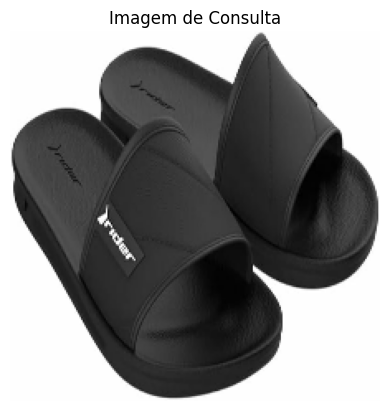

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


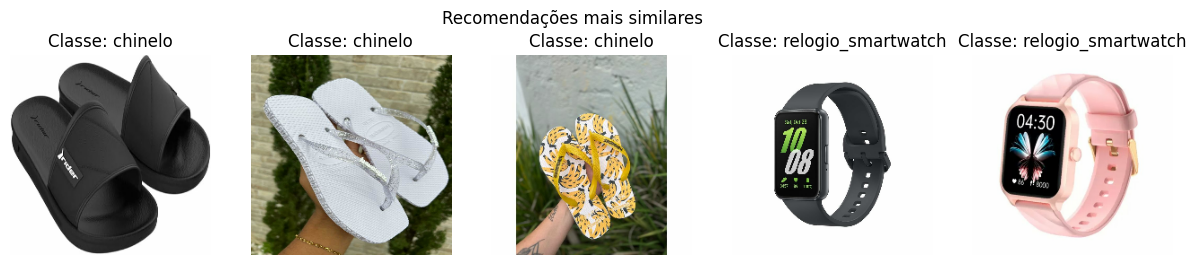

In [44]:
# Usar uma imagem de teste como consulta
img_consulta = all_images[4]  # você pode mudar o índice

plt.imshow(img_consulta.numpy().astype("uint8"))
plt.title("Imagem de Consulta")
plt.axis("off")
plt.show()

# Mostrar as recomendações
recomendar_similares(img_consulta)
